#### Importing required packages

In [2]:
import recordlinkage as rl, pandas as pd, numpy as np
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
from recordlinkage.preprocessing import phonetic
from numpy.random import choice
import collections, numpy
from IPython.display import clear_output
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt

#### Training data construction

In [3]:
# Certain helper functions were used as is from the code base since paper does not illustrate the steps taken
# to create certain aspects of the train data in detail
def generate_false_links(df, size):
    # A counterpart of generate_true_links(), with the purpose to generate random false pairs
    # for training. The number of false pairs in specified as "size".
    df["rec_id"] = df.index.values.tolist()
    indices_1 = []
    indices_2 = []
    unique_match_id = df["match_id"].unique()
    unique_match_id = unique_match_id[~np.isnan(unique_match_id)] # remove nan values
    for j in range(size):
            false_pair_ids = choice(unique_match_id, 2)
            candidate_1_cluster = df.loc[df['match_id'] == false_pair_ids[0]]
            candidate_1 = candidate_1_cluster.iloc[choice(range(len(candidate_1_cluster)))]
            candidate_2_cluster = df.loc[df['match_id'] == false_pair_ids[1]]
            candidate_2 = candidate_2_cluster.iloc[choice(range(len(candidate_2_cluster)))]    
            indices_1 = indices_1 + [candidate_1["rec_id"]]
            indices_2 = indices_2 + [candidate_2["rec_id"]]  
    links = pd.MultiIndex.from_arrays([indices_1,indices_2])
    return links

#Helper functions
def swap_fields_flag(f11, f12, f21, f22):
    return ((f11 == f22) & (f12 == f21)).astype(float)

def join_names_space(f11, f12, f21, f22):
    return ((f11+" "+f12 == f21) | (f11+" "+f12 == f22)| (f21+" "+f22 == f11)| (f21+" "+f22 == f12)).astype(float)

def join_names_dash(f11, f12, f21, f22):
    return ((f11+"-"+f12 == f21) | (f11+"-"+f12 == f22)| (f21+"-"+f22 == f11)| (f21+"-"+f22 == f12)).astype(float)

def abb_surname(f1, f2):
    return ((f1[0]==f2) | (f1==f2[0])).astype(float)

def reset_day(f11, f12, f21, f22):
    return (((f11 == 1) & (f12 == 1))|((f21 == 1) & (f22 == 1))).astype(float)


#Based on the Feature_set2 in the paper
def extract_features(df, links):
    c = rl.Compare()
    c.string('given_name', 'given_name', method='levenshtein', label='y_name_leven')
    c.string('surname', 'surname', method='levenshtein', label='y_surname_leven')  
    c.string('given_name', 'given_name', method='jarowinkler', label='y_name_jaro')
    c.string('surname', 'surname', method='jarowinkler', label='y_surname_jaro')  
    c.string('postcode', 'postcode', method='jarowinkler', label='y_postcode')      
    exact_fields = ['postcode', 'address_1', 'address_2', 'street_number']
    for field in exact_fields:
        c.exact(field, field, label='y_'+field+'_exact')
    c.compare_vectorized(reset_day,('day', 'month'), ('day', 'month'),label='reset_day_flag')    
    c.compare_vectorized(swap_fields_flag,('day', 'month'), ('day', 'month'),label='swap_day_month')    
    c.compare_vectorized(swap_fields_flag,('surname', 'given_name'), ('surname', 'given_name'),label='swap_names')    
    c.compare_vectorized(join_names_space,('surname', 'given_name'), ('surname', 'given_name'),label='join_names_space')
    c.compare_vectorized(join_names_dash,('surname', 'given_name'), ('surname', 'given_name'),label='join_names_dash')
    c.compare_vectorized(abb_surname,'surname', 'surname',label='abb_surname')
    
    feature_vectors = c.compute(links, df, df)
    return feature_vectors

In [4]:
trainset = 'ePBRN_F_dup'
PATH_DATA = "../data/"
df_train = pd.read_csv(PATH_DATA + trainset+".csv", index_col = "rec_id")
df_train['postcode'] = df_train['postcode'].astype(str)

ind_first = []
ind_second = []
processed = 0
df_train["rec_id"] = df_train.index.values.tolist()

for each in df_train["match_id"].unique():
    if each != -1:    
        processed = processed + 1
        links = df_train.loc[df_train['match_id'] == each]
        for j in range(len(links)-1):
            start = j+1
            end = len(links)
            for k in range(start, end):
                ind_first = ind_first + [links.iloc[j]["rec_id"]]
                ind_second = ind_second + [links.iloc[k]["rec_id"]]   
train_links  = pd.MultiIndex.from_arrays([ind_first, ind_second])

#Extracting features (both positve and negatve)
positive = extract_features(df_train, train_links)
train_links_negative = generate_false_links(df_train, len(train_links)) 
negative = extract_features(df_train, train_links_negative)

#X-train and Y-train creation - generate the feature vector X and the corresponding labels y
X_train = positive.values.tolist() + negative.values.tolist()
y_train = [1]*len(positive)+[0]*len(negative)
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_train = np.array(X_train)
y_train = np.array(y_train)

print("============================================================================================")
print("Train data creation success")
print("============================================================================================")
print("[1] Train data size :", len(df_train))
print("[2] Number of matched pairs :", str(len(train_links)))
print("[3] X_train sample :")
print(X_train[0:2])
print("[4] y train sample : ")
print(y_train[0:4])
print("============================================================================================")

Train data creation success
[1] Train data size : 14093
[2] Number of matched pairs : 3213
[3] X_train sample :
[[0.         0.45454545 0.         0.89090909 1.         1.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [1.         0.125      1.         0.58333333 1.         1.
  1.         1.         1.         0.         0.         0.
  0.         0.         0.        ]]
[4] y train sample : 
[1 1 1 1]


#### Testing data construction

In [5]:
testset = 'ePBRN_D_dup'
PATH_DATA = "../data/"
df_test = pd.read_csv(PATH_DATA + testset+".csv", index_col = "rec_id")
df_test['postcode'] = df_test['postcode'].astype(str)

ind_first = []
ind_second = []
processed = 0
df_test["rec_id"] = df_test.index.values.tolist()

for each in df_test["match_id"].unique():
    if each != -1:    
        processed = processed + 1
        links = df_test.loc[df_test['match_id'] == each]
        for j in range(len(links)-1):
            start = j+1
            end = len(links)
            for k in range(start, end):
                ind_first = ind_first + [links.iloc[j]["rec_id"]]
                ind_second = ind_second + [links.iloc[k]["rec_id"]]   
test_links  = pd.MultiIndex.from_arrays([ind_first, ind_second])

print("============================================================================================")
print("Test data creation success")
print("============================================================================================")
print("[1] Test data size :", len(df_test))
print("[2] Number of matched pairs :", str(len(test_links)))

# BLOCKING #
# Fields considered for blocking as per the paper
blocking_fields = ["given_name", "surname", "postcode"]
cand_pairs = []
counter = 3

def blocking_performance(options, true_links, df):
    i = 0
    for each in options:
        if df.loc[each[0]]["match_id"]==df.loc[each[1]]["match_id"]:
            i = i + 1
    return i

for each_field in blocking_fields:
    block_indexer = rl.Index()
    block_indexer.block(on=each_field)
    candidates = block_indexer.index(df_test)
    cand_pairs = candidates.union(cand_pairs)
    
    detects = blocking_performance(candidates, test_links, df_test)
    print("[" + str(counter) + "] Number of pairs of matched "+ each_field +": "+str(len(candidates)), ", detected ",
         detects,'/'+ str(len(test_links)) + " true matched pairs, missed " + 
          str(len(test_links)-detects) )
    counter += 1
    
detects = blocking_performance(cand_pairs, test_links, df_test)
print("[" + str(counter) + "] Number of pairs of at least 1 field matched: " + str(len(cand_pairs)), ", detected ",
     detects,'/'+ str(len(test_links)) + " true matched pairs, missed " + 
          str(len(test_links)-detects) )

Test data creation success
[1] Test data size : 11743
[2] Number of matched pairs : 2678
[3] Number of pairs of matched given_name: 252505 , detected  1606 /2678 true matched pairs, missed 1072
[4] Number of pairs of matched surname: 33057 , detected  1504 /2678 true matched pairs, missed 1174
[5] Number of pairs of matched postcode: 80556 , detected  2483 /2678 true matched pairs, missed 195
[6] Number of pairs of at least 1 field matched: 362633 , detected  2617 /2678 true matched pairs, missed 61


In [6]:
#Feature extraction
df_X_test = extract_features(df_test, cand_pairs)
vectors = df_X_test.values.tolist()
labels = [0]*len(vectors)
feature_index = df_X_test.index
for i in range(0, len(feature_index)):
    if df_test.loc[feature_index[i][0]]["match_id"]==df_test.loc[feature_index[i][1]]["match_id"]:
        labels[i] = 1
X_test, y_test = shuffle(vectors, labels, random_state=0)
X_test = np.array(X_test)
y_test = np.array(y_test)

print("[7] X_test sample :")
print(X_test[0:2])
print("[8] y test sample : ")
print(y_test[0:4])
print("============================================================================================")

[7] X_test sample :
[[0.2        0.         0.46666667 0.         1.         1.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [1.         0.         1.         0.55555556 0.77777778 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
[8] y test sample : 
[0 0 0 0]


#### Base Learners Classification

In [14]:
# Function to train the model based on model type and parameters given as input
def model_training(modeltype, modelparam, train_vectors, train_labels, modeltype_2):
    if modeltype == "svm":
        model = svm.SVC(C=modelparam, kernel=modeltype_2,random_state=0)
        model.fit(train_vectors, train_labels)
    elif modeltype == "lg":
        if modeltype_2 == "l1":
            model = LogisticRegression(C=modelparam, penalty=modeltype_2, class_weight=None, dual=False, fit_intercept=True,
                intercept_scaling=1, max_iter=5000, multi_class="ovr", n_jobs=1, random_state=None, solver="liblinear")
        if modeltype_2 == "l2":
            model = LogisticRegression(C=modelparam, penalty=modeltype_2, class_weight=None, dual=False, fit_intercept=True,
                intercept_scaling=1, max_iter=5000, multi_class="ovr", n_jobs=1, random_state=None)
        model.fit(train_vectors, train_labels)
    elif modeltype == "nn":  
        model = MLPClassifier(solver="lbfgs", alpha=modelparam, hidden_layer_sizes=(256,), activation=modeltype_2, random_state=None,
            batch_size="auto", learning_rate="constant", learning_rate_init=0.001, power_t=0.5, max_iter=30000, shuffle=True,
            tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False,
            validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        model.fit(train_vectors, train_labels)
    elif modeltype == "rf":
        model = RandomForestClassifier(n_estimators=100, criterion=modeltype_2, max_depth=7, min_samples_leaf=1,
            min_weight_fraction_leaf=0.0, max_features="sqrt", max_leaf_nodes=None, min_impurity_decrease=modelparam,
            bootstrap=True, oob_score=False, random_state=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
        model.fit(train_vectors, train_labels)

    return model

#Performance evaluation metrics
def performance_evaluation(test_labels, result):
    true_pos = np.logical_and(test_labels, result)
    count_true_pos = np.sum(true_pos)

    true_neg = np.logical_and(np.logical_not(test_labels), np.logical_not(result))
    count_true_neg = np.sum(true_neg)

    false_pos = np.logical_and(np.logical_not(test_labels), result)
    count_false_pos = np.sum(false_pos)

    false_neg = np.logical_and(test_labels, np.logical_not(result))
    count_false_neg = np.sum(false_neg)

    if count_true_pos == 0 and count_false_pos == 0:
        precision = 0
    else:
        precision = count_true_pos / (count_true_pos + count_false_pos)

    if count_true_pos == 0 and count_false_neg == 0:
        sensitivity = 0
    else:
        sensitivity = count_true_pos / (count_true_pos + count_false_neg)
        
    confusion_matrix = [count_true_pos, count_false_pos, count_false_neg, count_true_neg]
    no_links_found = np.count_nonzero(result)
    no_false = count_false_pos + count_false_neg
    
    if precision == 0 and sensitivity == 0:
        Fscore = 0
    else:    
        Fscore = 2 * precision * sensitivity / (precision + sensitivity)

    metrics_result = {"no_false": no_false, "confusion_matrix": confusion_matrix, "precision": precision,"sensitivity": sensitivity,
        "no_links": no_links_found, "F-score": Fscore, "true_pos": count_true_pos, "true_neg": count_true_neg,
        "false_pos": count_false_pos, "false_neg": count_false_neg}

    return metrics_result

In [8]:
print("============================================================================================")
print("BASE LEARNERS CLASSIFICATION PERFORMANCE:")

models = {"svm": ["linear", "rbf"], "lg": ["l1", "l2"], "nn": ["relu", "logistic"]}
modelparam_range = [.001,.002,.005,.01,.02,.05,.1,.2,.5,1,5,10,20,50,100,200,500,1000,2000,5000]

#Performance evaluation metrics
df_precision = pd.DataFrame()
df_precision["param"] = modelparam_range

df_sensitivity = pd.DataFrame()
df_sensitivity["param"] = modelparam_range

df_fscore = pd.DataFrame()
df_fscore["param"] = modelparam_range

df_nb_false = pd.DataFrame()
df_nb_false["param"] = modelparam_range

for i in models:
    for j in models[i]:
        print("============================================================================================")
        print("Model:", i, ", Param_1:", j, ", tuning range:", modelparam_range)
        precision = []
        sensitivity = []
        Fscore = []
        nb_false = []
        
        for modelparam in modelparam_range:
            md = model_training(i, modelparam, X_train, y_train, j)
            final_result = md.predict(X_test)
            final_eval = performance_evaluation(y_test, final_result)
            precision += [final_eval["precision"]]
            sensitivity += [final_eval["sensitivity"]]
            Fscore += [final_eval["F-score"]]
            nb_false += [final_eval["no_false"]]
        
        df_precision[i + "-" + j] = precision
        df_sensitivity[i + "-" + j] = sensitivity
        df_fscore[i + "-" + j] = Fscore
        df_nb_false[i + "-" + j] = nb_false

        print("No_false:", nb_false, "\n")
        print("Precision:", precision, "\n")
        print("Sensitivity:", sensitivity, "\n")
        print("F-score:", Fscore, "\n")
        print("")

BASE LEARNERS CLASSIFICATION PERFORMANCE:
Model: svm , Param_1: linear , tuning range: [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
No_false: [1264, 1775, 50920, 78198, 78224, 78225, 78225, 78227, 79916, 83257, 84197, 85219, 84340, 86702, 86375, 83815, 83528, 78442, 78423, 81702] 

Precision: [0.6829862050311063, 0.599105461393597, 0.04852789980371997, 0.032232110807164344, 0.032221741013425724, 0.03218661056799901, 0.03218661056799901, 0.03222054492811007, 0.03166313238412602, 0.03044207388084036, 0.030123257689206314, 0.02977274797340377, 0.030073717985578417, 0.02927839668588703, 0.02938598462714074, 0.03025639838941084, 0.03035720504753834, 0.032238960654402786, 0.03223497470072813, 0.030970144827831614] 

Sensitivity: [0.9648452426442491, 0.9724875811998471, 0.9919755445166221, 0.9950324799388612, 0.9950324799388612, 0.9938861291555215, 0.9938861291555215, 0.9950324799388612, 0.9984715322888804, 0.9988536492166603, 0.999

No_false: [92238, 89762, 86414, 84199, 85391, 75714, 82307, 83192, 78842, 79599, 72026, 61392, 32060, 5574, 1955, 1559, 1256, 2617, 2617, 2617] 

Precision: [0.027549632566132826, 0.028298312277397077, 0.029362538612749227, 0.030111738279000114, 0.029703870366582577, 0.033373763166294285, 0.030782637367813656, 0.030476079482547637, 0.032103615493217115, 0.031808008563226776, 0.03496053707103327, 0.04061215238154789, 0.07485488202847489, 0.31771668105042533, 0.5747515808491418, 0.6317887394120578, 0.6839686401730197, 0, 0, 0] 

Sensitivity: [0.9984715322888804, 0.9988536492166603, 0.9988536492166603, 0.9988536492166603, 0.9988536492166603, 0.9988536492166603, 0.9988536492166603, 0.9992357661444402, 0.9992357661444402, 0.9992357661444402, 0.9969430645777608, 0.9927397783721819, 0.9904470768055025, 0.9847153228888039, 0.9724875811998471, 0.9690485288498281, 0.9667558272831487, 0.0, 0.0, 0.0] 

F-score: [0.05361979807929081, 0.05503737235498474, 0.05704807839200366, 0.058461091169333644, 0

#### Perfomance plots

In [9]:
def plot_generation(df, title, ylabel, file_name):

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.locator_params(axis="x", nbins=22)
    ax.locator_params(axis="y", nbins=12)
    for i in df.columns[1:]:
        plt.plot(df[i], label=i)

    plt.xlabel("Hyperparameters")
    plt.ylabel(ylabel)
    plt.title(title)
    xlabels = df["param"]
    ax.set_xticklabels(xlabels, rotation="vertical")
    ax.legend(loc="best", shadow=True, fontsize="large")
    fig.savefig(PATH_OUTPUT_IMG + file_name, bbox_inches="tight")

C:\Users\Prasanna Ramraj\AppData\Local\Temp\ipykernel_18220\3863483043.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation="vertical")


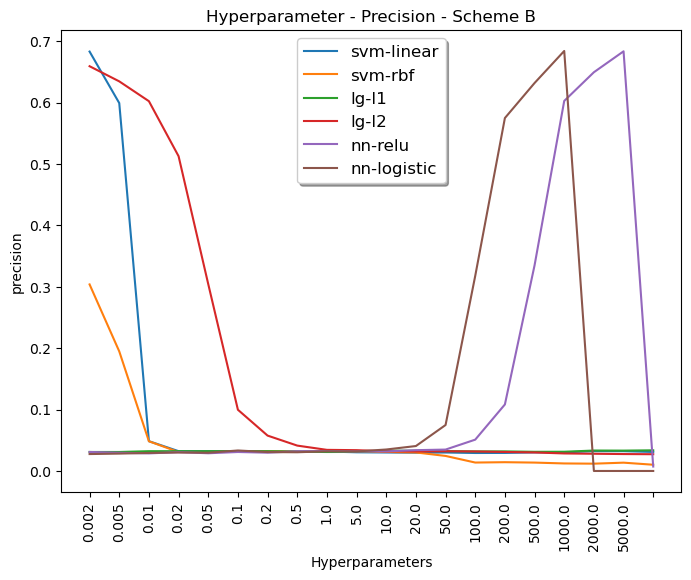

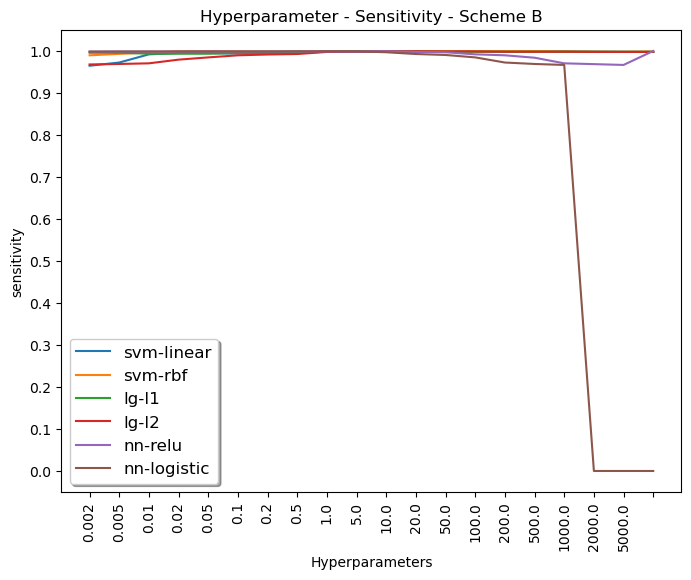

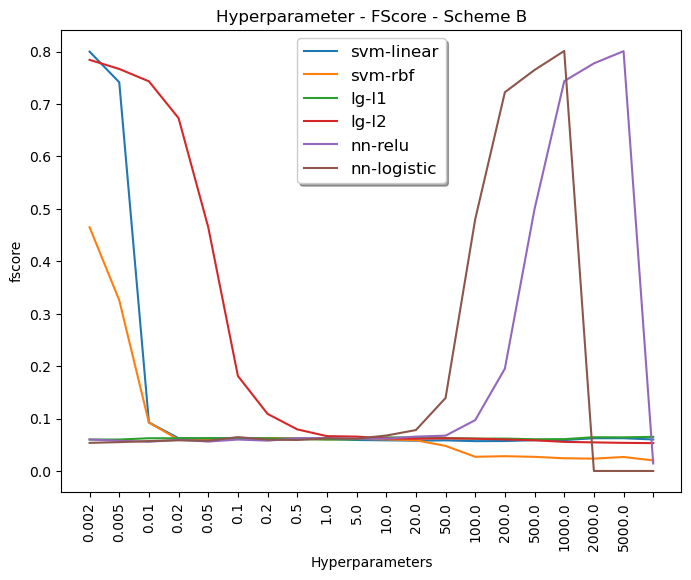

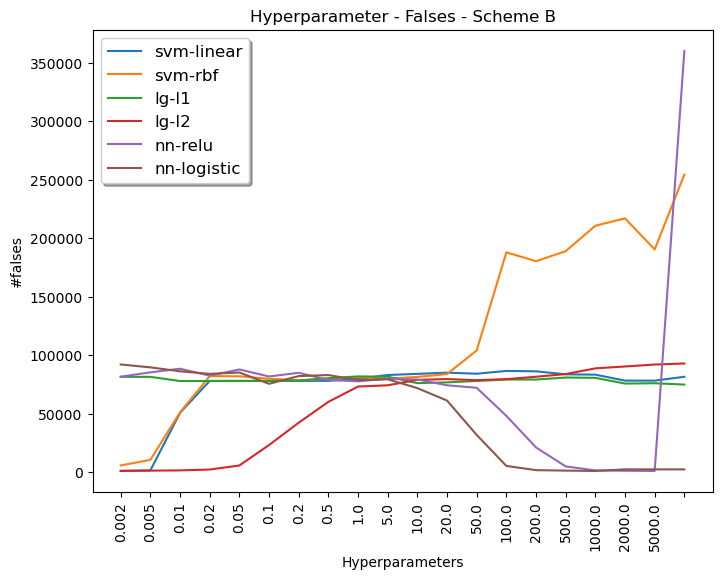

In [10]:
PATH_OUTPUT_CSV = "../output/ePBRN_csv/"
PATH_OUTPUT_IMG = "../output/ePBRN_img/"

plot_generation(df_precision, "Hyperparameter - Precision - Scheme B", "precision", "precision.png")
plot_generation(df_sensitivity, "Hyperparameter - Sensitivity - Scheme B", "sensitivity", "sensitivity.png")
plot_generation(df_fscore, "Hyperparameter - FScore - Scheme B", "fscore", "fscore.png")
plot_generation(df_nb_false, "Hyperparameter - Falses - Scheme B", "#falses", "falses.png")

df_precision.to_csv(PATH_OUTPUT_CSV + "precision.csv")
df_sensitivity.to_csv(PATH_OUTPUT_CSV + "sensitivity.csv")
df_fscore.to_csv(PATH_OUTPUT_CSV + "fscore.csv")
df_nb_false.to_csv(PATH_OUTPUT_CSV + "falses.csv")

#### Bagging and Stacking

In [11]:
print("============================================================================================")
print("BAGGING PERFORMANCE:")

nFold = 10
kf = KFold(n_splits=nFold)

modeltypes = ["svm", "nn", "lg"]
modeltypes_2 = ["linear", "relu", "l2"]
modelparams = [0.001, 2000, 0.005]

model_raw_score = [0] * len(modeltypes)
model_binary_score = [0] * len(modeltypes)
model_i = 0

df_bagging = pd.DataFrame(columns=["model", "no_false", "confusion_matrix", "precision", "sensitivity", "no_links",
        "F-score", "true_pos", "true_neg", "false_pos", "false_neg"])

for model_i in range(len(modeltypes)):
    modeltype = modeltypes[model_i]
    modeltype_2 = modeltypes_2[model_i]
    modelparam = modelparams[model_i]

    print(modeltype, "per fold:")
    iFold = 0
    result_fold = [0] * nFold
    final_eval_fold = [0] * nFold
    
    for train_index, _ in kf.split(X_train):
        X_train_fold = X_train[train_index]
        y_train_fold = y_train[train_index]
        md = model_training(modeltype, modelparam, X_train_fold, y_train_fold, modeltype_2)
        result_fold[iFold] = md.predict(X_test)
        final_eval_fold[iFold] = performance_evaluation(y_test, result_fold[iFold])
        print("Fold", str(iFold), final_eval_fold[iFold])
        iFold = iFold + 1
    bagging_raw_score = np.average(result_fold, axis=0)
    bagging_binary_score = np.copy(bagging_raw_score)
    bagging_binary_score[bagging_binary_score > 0.5] = 1
    bagging_binary_score[bagging_binary_score <= 0.5] = 0
    bagging_eval = performance_evaluation(y_test, bagging_binary_score)
    print(modeltype, "bagging:", bagging_eval)
    print("")
    model_raw_score[model_i] = bagging_raw_score
    model_binary_score[model_i] = bagging_binary_score

    model = (modeltypes[model_i] + " - " + modeltypes_2[model_i] + " - " + str(modelparams[model_i]))
    df_bagging.loc[model_i] = [model] + [v for _, v in bagging_eval.items()]


BAGGING PERFORMANCE:
svm per fold:
Fold 0 {'no_false': 1263, 'confusion_matrix': [2522, 1168, 95, 358848], 'precision': 0.6834688346883468, 'sensitivity': 0.9636988918609094, 'no_links': 3690, 'F-score': 0.7997463136197874, 'true_pos': 2522, 'true_neg': 358848, 'false_pos': 1168, 'false_neg': 95}
Fold 1 {'no_false': 1263, 'confusion_matrix': [2522, 1168, 95, 358848], 'precision': 0.6834688346883468, 'sensitivity': 0.9636988918609094, 'no_links': 3690, 'F-score': 0.7997463136197874, 'true_pos': 2522, 'true_neg': 358848, 'false_pos': 1168, 'false_neg': 95}
Fold 2 {'no_false': 1261, 'confusion_matrix': [2524, 1168, 93, 358848], 'precision': 0.6836403033586133, 'sensitivity': 0.9644631257164692, 'no_links': 3692, 'F-score': 0.8001268029798699, 'true_pos': 2524, 'true_neg': 358848, 'false_pos': 1168, 'false_neg': 93}
Fold 3 {'no_false': 1261, 'confusion_matrix': [2524, 1168, 93, 358848], 'precision': 0.6836403033586133, 'sensitivity': 0.9644631257164692, 'no_links': 3692, 'F-score': 0.80012

In [12]:
print("============================================================================================")
print("STACKING PERFORMANCE:\n")

thres = 0.99

stack_raw_score = np.average(model_raw_score, axis=0)
stack_binary_score = np.copy(stack_raw_score)
stack_binary_score[stack_binary_score > thres] = 1
stack_binary_score[stack_binary_score <= thres] = 0
stacking_eval = performance_evaluation(y_test, stack_binary_score)
print(stacking_eval)

model = "stack bagging"
df_bagging.loc[len(df_bagging)] = [model] + [v for _, v in stacking_eval.items()]
df_bagging.to_csv(PATH_OUTPUT_CSV + "bagging.csv")

STACKING PERFORMANCE:

{'no_false': 925, 'confusion_matrix': [2518, 826, 99, 359190], 'precision': 0.7529904306220095, 'sensitivity': 0.9621704241497898, 'no_links': 3344, 'F-score': 0.8448246938433148, 'true_pos': 2518, 'true_neg': 359190, 'false_pos': 826, 'false_neg': 99}


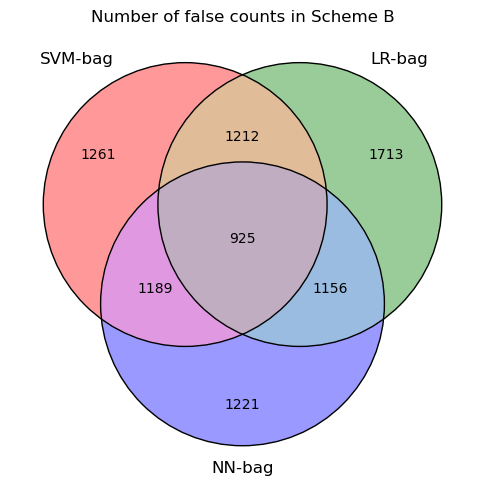

In [8]:
from matplotlib_venn import venn3, venn3_circles
PATH_OUTPUT_IMG = "../output/ePBRN_img/"

fig, ax = plt.subplots(figsize=(6, 6))
v = venn3(subsets=(1, 1, 1, 1, 1, 1, 1), set_labels = ('SVM-bag', 'LR-bag', 'NN-bag'))
c = venn3_circles(subsets=(1, 1, 1, 1, 1, 1, 1),  linewidth=1)
v.get_label_by_id('001').set_text('1221')
v.get_label_by_id('010').set_text('1713')
v.get_label_by_id('011').set_text('1156')
v.get_label_by_id('111').set_text('925')
v.get_label_by_id('110').set_text('1212')
v.get_label_by_id('101').set_text('1189')
v.get_label_by_id('100').set_text('1261')
plt.title("Number of false counts in Scheme B")
plt.show()
fig.savefig(PATH_OUTPUT_IMG + 'B_ePBRN_venn.png', bbox_inches='tight')